In [232]:
# Color map stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

from scipy.optimize import minimize
from levlabpython.cqedanalysis.cavity_tools import find_center_and_waist, fractional_ft

# TODO: register these colors with matplotlib so that all can be accessed at once
levlab_colors = {'bll:blue':'#145087', 'bll:red':'#9e1519',
                 'bll:green':'#00625a', 'bll:orange':'#ff8000',
                 'bll:purple':'#490634'}

def levlab_map(colororder, mapname, colornodes = None):
    if colornodes is None:
        colornodes = np.linspace(0,1,len(colororder))
    else:
        assert len(colornodes) == len(colororder),"You need to specify the same number of nodes as colors!"

    # if the color is not in the levlab dictionary, then return itself
    # hopefully it is in the matplotlib library
    colors = [levlab_colors.get(c,c) for c in colororder]
    return mcolors.LinearSegmentedColormap.from_list(mapname, list(zip(colornodes,colors)))

spinmap = levlab_map(['bll:blue','bll:red'],"bll_spin")
phasemap = levlab_map(['bll:blue','bll:green','bll:orange','bll:red','bll:blue'],"bll_phase")

def colorwheel_rgba(radius, angle, colormap, gamma = 1, anglemax = 2*np.pi, rescale = 'max'):
    """
    Convenience function for plotting complex data
    """
    assert radius.shape == angle.shape,"You are supposed to specify radius and angle for each pixel (a la meshgrid), something went wrong!"
    if rescale == 'max':
        rescale = np.max(radius)
    radius = radius/rescale
    if np.max(radius) > 1:
        print("Warning: Your rescaling leaves an alpha value larger than 1, so clipping it!")
        radius = np.minimum(radius,1)
    rgba = colormap(angle/anglemax) # creates the correct RGB values, but all A are one
    rgba[...,3] = radius**gamma # overwrite the A channel

    return rgba

def phase_rgba(phase, fieldstrength, **kwargs):
    """
    Calculating RGBA values using our phase map for electric fields.
    Supercedes phase_rgba_converging()
    """
    phase = np.mod(phase,2*np.pi)
    neg_index = np.where(phase<0)
    phase[neg_index] = phase[neg_index]+2*np.pi
    return colorwheel_rgba(fieldstrength, phase, phasemap, **kwargs)

def complex2d_plot(field, ax=None):
    if ax is None:
        fig,ax = plt.subplots()
    rgba = phase_rgba(np.angle(field),np.abs(field),gamma=1)
    im=ax.imshow(rgba)
    ax.set_xlabel("Position [w0]",fontsize=12)
    ax.set_ylabel("Position [w0]",fontsize=12)
    # plt.colorbar(im)

In [276]:
def MehlerG_1d(x1,x2,phi, expnorm=0.):
    arg  = -( (x1-x2)**2 )/(2*np.tanh(phi/2))
    arg += -( (x1+x2)**2 )/(2/np.tanh(phi/2))
    
    return np.exp(arg+expnorm)/np.sqrt(np.pi*(1-np.exp(-2*phi)))

def G_eta(x1, y1, x2, y2, M, N, eta, phi, expnorm_x=0, expnorm_y=0):
    rslt = 0.j*x2
    for s in range(N):
        term1_x = MehlerG_1d(x1,x2, phi - 1j*2*s*np.pi/N, expnorm=expnorm_x)
        term1_y = MehlerG_1d(y1,y2, phi - 1j*2*s*np.pi/N, expnorm=expnorm_y)
        rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x * term1_y*np.exp(-2j*np.pi*s*eta/N)

    return rslt/N

def Mehler_Gaussian(x1,y1,theta_x,theta_y,spot_w, x2,y2, k=0.780/34.818):
    # x1, y1 DMD spot coordinates
    # theta_x, theta_y the x and y angles of the DMD beam
    # spot sigma is 1/4 of the intensity width
    # x2, y2 test charge coordinates

    comp_x1 = (x1 + 2j*np.tan(theta_x)/(k*spot_w))/np.sqrt(1-np.square(spot_w))
    comp_y1 = (y1 + 2j*np.tan(theta_y)/(k*spot_w))/np.sqrt(1-np.square(spot_w))

    beam_phi = np.arctan(np.square(spot_w))

    expnorm_x = -np.square(np.imag(comp_x1))/np.real(np.square(spot_w)) #- np.square(comp_x1)/(1-np.square(spot_w))
    expnorm_y = -np.square(np.imag(comp_y1))/np.real(np.square(spot_w)) #- np.square(comp_y1)/(1-np.square(spot_w))

    print(expnorm_x, expnorm_y)

    term1 = np.exp(-(comp_x1-x2)**2 /np.square(spot_w) + expnorm_x)
    term2 = np.exp(-(comp_y1-y2)**2 /np.square(spot_w) + expnorm_y)

    # term1 = MehlerG_1d(comp_x1, x2, beam_phi, expnorm=expnorm_x)
    # term2 = MehlerG_1d(comp_y1, y2, beam_phi, expnorm=expnorm_y)

    norm = np.power(2/np.pi*np.real(1/np.square(spot_w)),0.25)

    return norm*(term1*term2)

def ForwardGreens(x1,y1,z1,theta_x,theta_y,spot_w, x2,y2,z2,M=4,N=7,a=0.01,eta=0, k=0.780/34.818, phi=0.):
    # x1, y1 DMD spot coordinates
    # theta_x, theta_y the x and y angles of the DMD beam
    # spot sigma is 1/4 of the intensity width
    # x2, y2 test charge coordinates

    comp_x1 = (x1 + 2j*np.tan(theta_x)/(k*spot_w))/np.sqrt(1-np.square(spot_w))
    comp_y1 = (y1 + 2j*np.tan(theta_y)/(k*spot_w))/np.sqrt(1-np.square(spot_w))

    beam_phi = np.arctan(np.square(spot_w))
    expnorm_x = -np.square(np.real(2*np.tan(theta_x)/(k*spot_w)))/np.real(np.square(spot_w)) - np.square(x1 + 2j*np.tan(theta_x)/(k*spot_w))/(1-np.square(spot_w))
    expnorm_y = -np.square(np.real(2*np.tan(theta_y)/(k*spot_w)))/np.real(np.square(spot_w)) - np.square(y1 + 2j*np.tan(theta_y)/(k*spot_w))/(1-np.square(spot_w))

    term1 = G_eta(comp_x1, comp_y1, x2, y2, M, N, eta, phi-1j*(np.arctan(z2)+np.arctan(z1))+beam_phi, expnorm_x=expnorm_x, expnorm_y=expnorm_y)
    term2 = G_eta(comp_x1, comp_y1, x2, y2, M, N, eta, phi+1j*(np.arctan(z2)-np.arctan(z1))-1j*M*np.pi/N+beam_phi, expnorm_x=expnorm_x, expnorm_y=expnorm_y)

    return np.power(2/np.pi*np.real(1/spot_w),0.25)*(term1+term2)

-0.0 -82.35098721869679


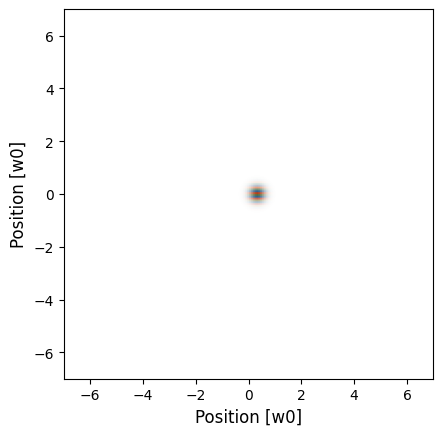

In [277]:
# Plotting a Green function and including a angle for the source beam
# Source location (units of w0)
x0 = 0.3
y0 = 0.
z0 = 0.
z1 = 0.
sz = 200
lim = 7
x = np.linspace(-lim,lim,sz)
dx = x[1]-x[0]
y = np.linspace(-lim,lim,sz)
xx,yy = np.meshgrid(x,y)

wt = 0.3
theta_beam = 0.5/180.0*np.pi


field = Mehler_Gaussian(x0,y0, 0.0,theta_beam,wt, xx, yy)
# field = Greens(x0,y0,xx,yy)

# Complex plot
rgba = phase_rgba(np.angle(field),np.abs(field),gamma=1)

fig = plt.figure()
im=plt.imshow(rgba,extent=(-lim,lim,-lim,lim))
plt.xlabel("Position [w0]",fontsize=12)
plt.ylabel("Position [w0]",fontsize=12)
# plt.colorbar(im)
plt.show()

In [278]:
dx = xx[0,1]-xx[0,0]
dy = yy[1,0]-yy[0,0]
np.sum(np.square(np.abs(field)))*dx*dy

0.3759942411946381

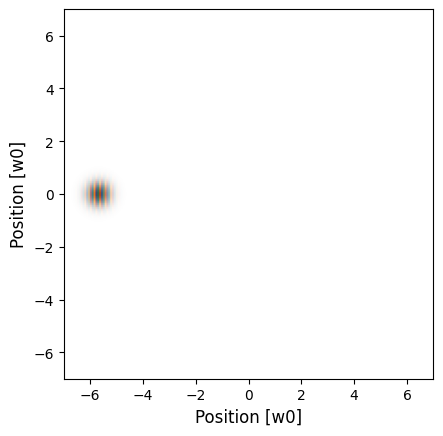

In [103]:
# Plotting a Green function and including a angle for the source beam

# Source location (units of w0)
x0 = 0.3
y0 = 0.
z0 = 0.

z1 = 0.

sz = 200
lim = 7
x = np.linspace(-lim,lim,sz)
dx = x[1]-x[0]
y = np.linspace(-lim,lim,sz)
xx,yy = np.meshgrid(x,y)

wt = 0.3
theta_beam = 1./180.0*np.pi



field = ForwardGreens(x0,y0, 0.1,theta_beam,0.,wt, xx, yy, 0.0)
# field = Greens(x0,y0,xx,yy)

# Complex plot
rgba = phase_rgba(np.angle(field),np.abs(field),gamma=1)

fig = plt.figure()
im=plt.imshow(rgba,extent=(-lim,lim,-lim,lim))
plt.xlabel("Position [w0]",fontsize=12)
plt.ylabel("Position [w0]",fontsize=12)
# plt.colorbar(im)
plt.show()

In [104]:
field[50,50]

(-4.0415558393728335e-142-4.704973711636896e-143j)

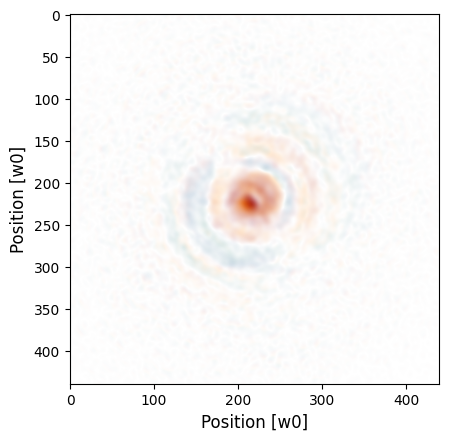

In [162]:
field = np.load("DMDFieldNPYs/shot0.npy")
complex2d_plot(field)

In [163]:
field.shape

(440, 440)

In [164]:
sz = 440
lim = 7
x = np.linspace(-lim,lim,sz)
dx = x[1]-x[0]
y = np.linspace(-lim,lim,sz)
xx,yy = np.meshgrid(x,y)

x_cent, y_cent, w0_x, w0_y = find_center_and_waist(field,xx,yy,xx,yy, 4/7*np.pi)

xx_new = (xx - x_cent)/w0_x
yy_new = (yy - y_cent)/w0_y
limx_new = lim/w0_x
limy_new = lim/w0_y

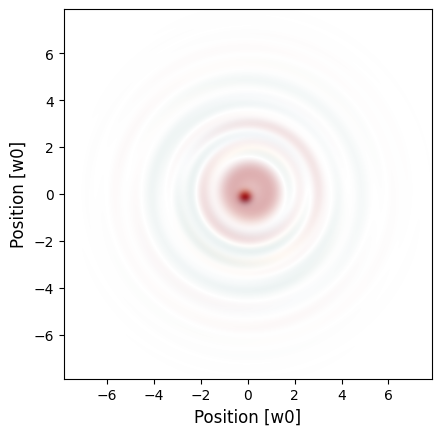

In [167]:
x0 = -0.1
y0 = 0.1
z0 = 0.
z1 = 0.
wt = 1./4.
theta_beam_x = -0.0/180.0*np.pi
theta_beam_y = 0.01/180.0*np.pi
overall_amp = 1.0
overall_phase = 3*np.pi/2


model_field = overall_amp*np.exp(1j*overall_phase)*ForwardGreens(x0,y0,z0,theta_beam_x,theta_beam_y,wt, xx, yy, 0.0)
# field = Greens(x0,y0,xx,yy)

# Complex plot
rgba = phase_rgba(np.angle(model_field),np.abs(model_field),gamma=1)

fig = plt.figure()
im=plt.imshow(rgba,extent=(-limx_new,limx_new,-limy_new,limy_new))
plt.xlabel("Position [w0]",fontsize=12)
plt.ylabel("Position [w0]",fontsize=12)
# plt.colorbar(im)
plt.show()

In [148]:
x0 = -0.1
y0 = 0.1
z0 = 0.
z1 = 0.
wt = 1./6.
theta_beam_x = -0.03/180.0*np.pi
theta_beam_y = 0.04/180.0*np.pi
overall_amp = 1.0
overall_phase = 3*np.pi/2

def fitting_cost(params):
    x0 = params[0]
    y0 = params[1]
    z0 = params[2]
    z1 = params[3]
    wt = params[4]
    theta_beam_x = params[5]
    theta_beam_y = params[6]
    overall_amp = params[7]
    overall_phase = params[8]
    
    model_field = overall_amp*np.exp(1j*overall_phase)*ForwardGreens(x0,y0,z0,theta_beam_x,theta_beam_y,wt, xx, yy, z1)
    err = field - model_field
    cost = np.linalg.norm(err)**2
    return cost/(field.shape[0]*field.shape[1])

rslt = minimize(fitting_cost,[x0,y0,z0,z1,wt,theta_beam_x,theta_beam_y,overall_amp,overall_phase])
    

/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_73089/3537358915.py:5: RuntimeWarning: overflow encountered in exp
  return np.exp(arg+expnorm)/np.sqrt(np.pi*(1-np.exp(-2*phi)))
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_73089/3537358915.py:5: RuntimeWarning: invalid value encountered in divide
  return np.exp(arg+expnorm)/np.sqrt(np.pi*(1-np.exp(-2*phi)))
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_73089/3537358915.py:12: RuntimeWarning: invalid value encountered in multiply
  rslt += np.exp(-1j*np.pi*eta*M/N)*term1_x * term1_y*np.exp(-2j*np.pi*s*eta/N)
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_73089/3537358915.py:43: RuntimeWarning: invalid value encountered in sqrt
  comp_x1 = (x1 + 2j*np.tan(theta_x)/(k*spot_w))/np.sqrt(1-np.square(spot_w))
/var/folders/4w/vyhp34ws43v7kxy3v5hv8y740000gn/T/ipykernel_73089/3537358915.py:43: RuntimeWarning: invalid value encountered in scalar divide
  comp_x1 = (x1 + 2j*np.tan(theta_x)/(k*spot

KeyboardInterrupt: 

In [65]:
rslt["success"]

False